In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


Bu kılavuz, 10 kategoride 70.000 gri tonlamalı görüntü içeren Fashion MNIST veri kümesini kullanır. Görüntüler, burada görüldüğü gibi düşük çözünürlükte (28 x 28 piksel) tek tek giyim eşyalarını göstermektedir: 

![](fashion-mnist-sprite.png)

Fashion MNIST, genellikle bilgisayarla görme için makine öğrenimi programlarının "Merhaba Dünyası" olarak kullanılan klasik MNIST veri kümesinin yerini alacak şekilde tasarlanmıştır. MNIST veri kümesi, burada kullanacağınız giyim eşyalarının formatına benzer bir biçimde el yazısı rakamların (0, 1, 2, vb.) görüntülerini içerir.

 Bu kılavuz, Fashion MNIST'i çeşitlilik için kullanır ve çünkü bu, normal MNIST'ten biraz daha zorlayıcı bir problemdir. Her iki veri kümesi de nispeten küçüktür ve bir algoritmanın beklendiği gibi çalıştığını doğrulamak için kullanılır. Kodu test etmek ve hata ayıklamak için iyi başlangıç noktalarıdır.

Burada, ağı eğitmek için 60.000 görüntü ve ağın görüntüleri sınıflandırmayı ne kadar doğru öğrendiğini değerlendirmek için 10.000 görüntü kullanılır. Fashion MNIST'e doğrudan TensorFlow'dan erişebilirsiniz.

## Veri setini yüklemek

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

Görüntüler, 0 ile 255 arasında değişen piksel değerlerine sahip 28x28 NumPy dizileridir. Etiketler , 0 ile 9 arasında değişen bir tamsayı dizisidir. Bunlar, görüntünün temsil ettiği giysi sınıfına karşılık gelir:

![](classes.png)
Her görüntü tek bir etikete eşlenir. Sınıf adları veri kümesine dahil edilmediğinden, daha sonra görüntüleri çizerken kullanmak üzere bunları saklamak gereklidir.

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Verileri keşfetmek

Modeli eğitmeden önce veri kümesinin biçimini keşfedelim. Aşağıdakiler, eğitim ve test setinde her bir görüntünün 28 x 28 piksel olarak temsil edildiği 60.000 görüntü olduğunu göstermektedir.

In [4]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

## Veri ön işleme

Ağı eğitmeden önce veriler önceden işlenmelidir. Eğitim setindeki ilk görüntüyü incelerseniz piksel değerlerinin 0 ile 255 aralığında olduğunu göreceksiniz.

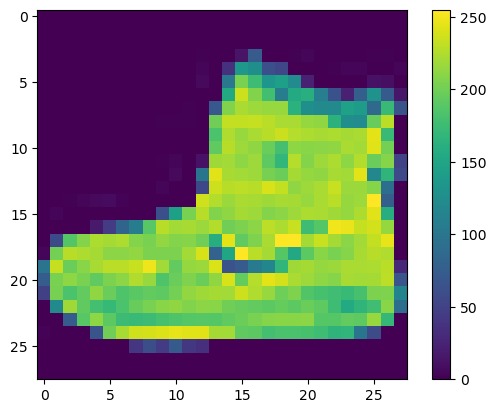

In [5]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.show()

Sinir ağı modeline beslemeden önce bu değerleri 0 ile 1 arasında ölçeklendirin. Bunu yapmak için değerleri 255'e bölün. Eğitim setinin ve test setinin aynı şekilde ön işleme tabi tutulması önemlidir.

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Verilerin doğru formatta olduğunu ve ağı kurmaya ve eğitmeye hazır olduğunuzu doğrulamak için, eğitim setinden ilk 25 görüntüyü görüntüleyelim ve her görüntünün altında sınıf adını görüntüleyelim.

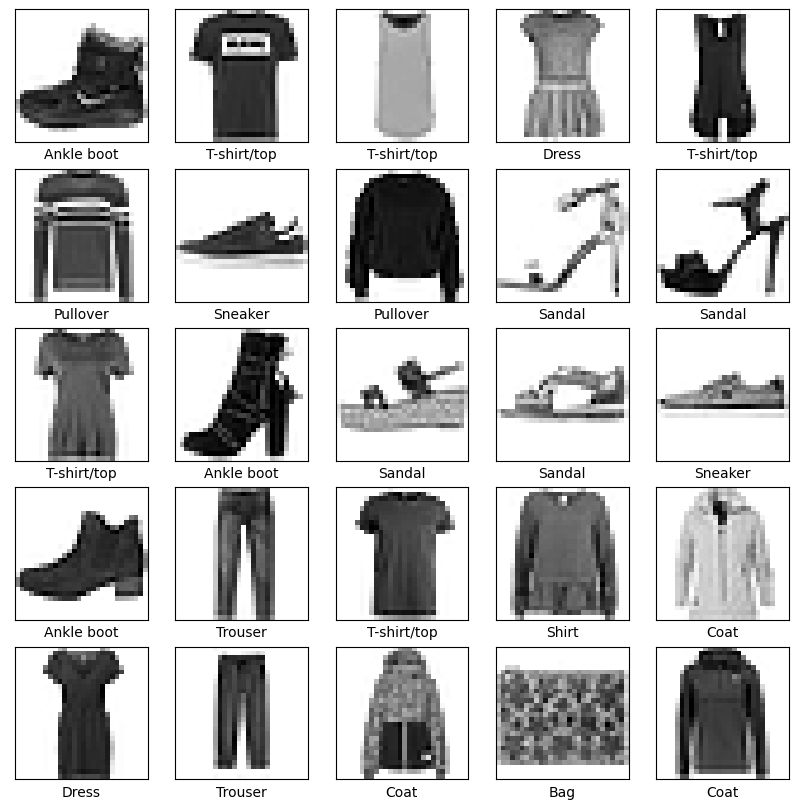

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

## Model oluşturma

Sinir ağının oluşturulması, modelin katmanlarının yapılandırılmasını ve ardından modelin derlenmesini gerektirir.
Katmanları ayarlayın

<b>Katmanları ayarlayın</b>

Bir sinir ağının temel yapı taşı katmandır . Katmanlar, kendilerine beslenen verilerden temsilleri çıkarır. Umarım, bu temsiller eldeki sorun için anlamlıdır.

Derin öğrenmenin çoğu, basit katmanları birbirine zincirlemekten oluşur. tf.keras.layers.Dense gibi çoğu katman, eğitim sırasında öğrenilen parametrelere sahiptir.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)), # Input'u düzleştirir.
    tf.keras.layers.Dense(128, activation='relu'), # Hidden layer ve belirlenen nöron sayısı
    tf.keras.layers.Dense(10) # Output
])

Bu ağdaki ilk katman olan Flatten , görüntülerin formatını iki boyutlu bir diziden (28 x 28 piksel) tek boyutlu bir diziye (28 * 28 = 784 piksel) dönüştürür. Bu katmanı, görüntüdeki piksel sıralarını kaldırmak ve bunları hizalamak olarak düşünün. Bu katmanın öğrenilecek parametresi yoktur; yalnızca verileri yeniden biçimlendirir.

Pikseller düzleştirildikten sonra ağ, iki Dense katmanından oluşan bir diziden oluşur. Bunlar yoğun şekilde bağlı veya tamamen bağlı sinir katmanlarıdır. İlk Dense katmanda 128 düğüm (veya nöron) bulunur. İkinci (ve son) katman, 10 uzunluğunda bir logits dizisi döndürür. Her düğüm, geçerli görüntünün 10 sınıftan birine ait olduğunu gösteren bir puan içerir.

## Modeli derleme

Model eğitime hazır olmadan önce birkaç ayara daha ihtiyacı var. Bunlar, modelin derleme adımı sırasında eklenir:

- loss: Bu, eğitim sırasında modelin ne kadar doğru olduğunu ölçer. Modeli doğru yöne "yönlendirmek" için bu işlevi en aza indirmek istiyorsunuz. 
- optimizer: Model, gördüğü verilere ve kayıp işlevine göre bu şekilde güncellenir.
- metrics: Eğitim ve test adımlarını izlemek için kullanılır. Aşağıdaki örnek, doğru sınıflandırılmış görüntülerin kesri olan 'accuracy' kullanır.

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

## Modeli eğitme

Sinir ağı modelinin eğitimi aşağıdaki adımları gerektirir:

1. Eğitim verilerini modele besleyin. Bu örnekte, eğitim verileri X_train ve y_train dizilerindedir.
2. Model, görüntüleri ve etiketleri ilişkilendirmeyi öğrenir.
3. Modelden bir test seti hakkında tahminler yapmasını istersiniz - bu örnekte X_test dizisi.
4. Tahminlerin y_test dizisindeki etiketlerle eşleştiğini doğrulayın.

In [10]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4978 - accuracy: 0.8256
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3761 - accuracy: 0.8636
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3394 - accuracy: 0.8769
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3152 - accuracy: 0.8853
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2956 - accuracy: 0.8912
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2818 - accuracy: 0.8958
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2685 - accuracy: 0.9013
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2570 - accuracy: 0.9039
Epoch 9/10
1875/1875 [==============================] - 2s 966us/step - loss: 0.2464 - accuracy: 0.9097
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2

Model ilerlerken, kayıp ve doğruluk metrikleri görüntülenir. Bu model, eğitim verilerinde yaklaşık 0.91 (veya %91) doğruluğa ulaşır.

## Modelin değerlendirilmesi

Doğruluğu değerlendirin.

Ardından, modelin test veri kümesinde nasıl performans gösterdiğini karşılaştırın.

In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

313/313 - 0s - loss: 0.3413 - accuracy: 0.8842


Test veri setindeki doğruluğun, eğitim veri setindeki doğruluktan biraz daha az olduğu ortaya çıktı. Eğitim doğruluğu ve test doğruluğu arasındaki bu boşluk, fazla uydurmayı temsil eder. Bir makine öğrenimi modeli, yeni, daha önce görülmemiş girdilerde eğitim verilerinde olduğundan daha kötü performans gösterdiğinde, aşırı uyum gerçekleşir. Fazla takılan bir model, eğitim veri kümesindeki gürültüyü ve ayrıntıları, modelin yeni veriler üzerindeki performansını olumsuz yönde etkileyecek bir noktaya "belleğe alır".

## Tahminler

Eğitilen model ile bazı görüntüler hakkında tahminler yapmak için kullanabilirsiniz. Modelin doğrusal çıktılarını - logitleri - yorumlaması daha kolay olması gereken olasılıklara dönüştürmek için bir softmax katmanı ekleyin.

In [12]:
probability_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

In [13]:
predictions = probability_model.predict(X_test)
predictions[0]

array([8.6065857e-06, 1.1681059e-07, 1.4688299e-06, 1.8916728e-08,
       2.3069492e-06, 2.0553410e-04, 8.6528125e-06, 2.0903667e-02,
       8.1451872e-06, 9.7886151e-01], dtype=float32)

Tahmin, 10 sayıdan oluşan bir dizidir. Modelin, görüntünün 10 farklı giysi parçasının her birine karşılık geldiğine dair "olasılıkarını" temsil ediyorlar. Hangi etiketin en yüksek güven değerine sahip olduğunu 'np.argmax' fonksiyonu ile görebilirsiniz

In [14]:
np.argmax(predictions[0])

9

In [15]:
y_test[0]

9

In [16]:
class_names[9]

'Ankle boot'

Model, bu görüntünün bir ayak bileği botu veya class_names[9] olduğundan en çok emindir. Test etiketinin incelenmesi, bu sınıflandırmanın doğru olduğunu gösterir.

10 sınıf tahmininin tamamına bakmak için bunun grafiğini çizmelisiniz.

In [17]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                            100*np.max(predictions_array),
                            class_names[true_label]),
                            color=color)
    
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')


## Tahminleri doğrulamak

In [18]:
def predict_validation(i):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(1,2,2)
    plot_value_array(i, predictions[i], y_test)
    plt.show()

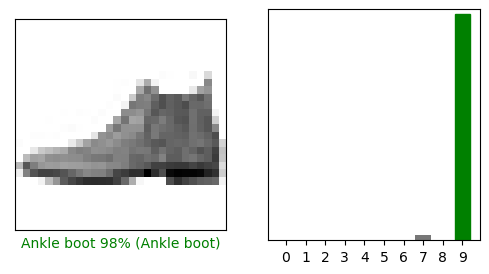

In [19]:
predict_validation(0)

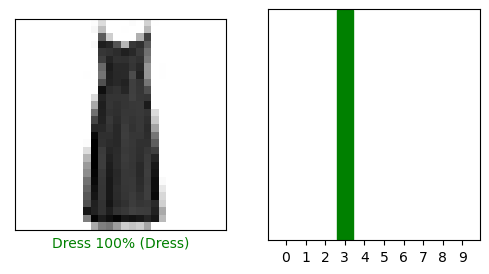

In [20]:
predict_validation(13)

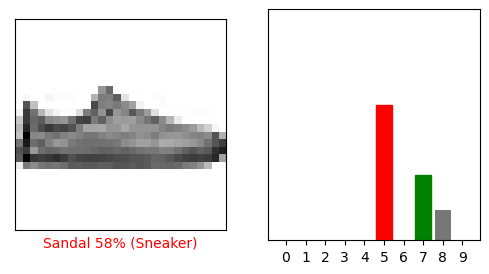

In [21]:
predict_validation(12)

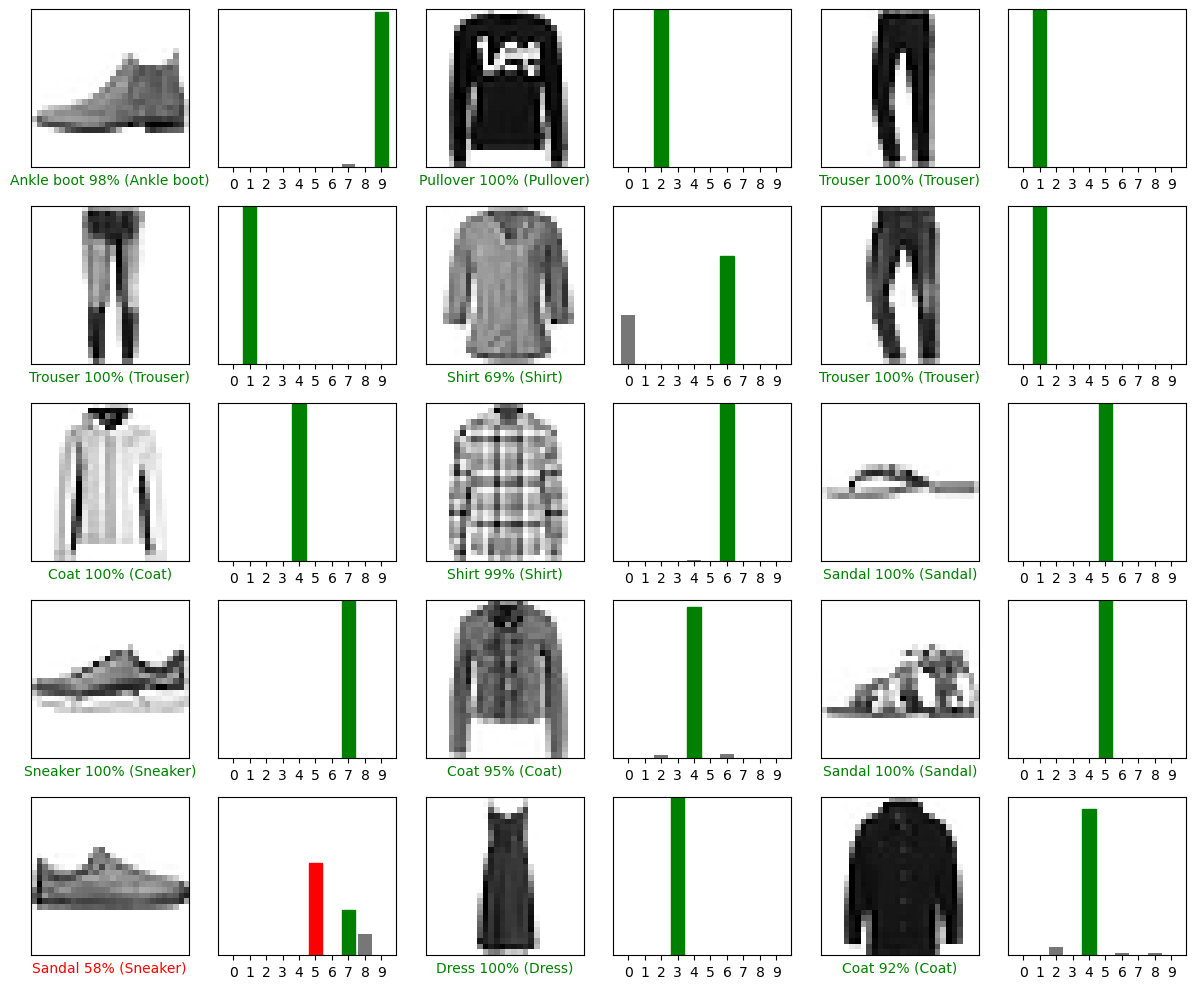

In [22]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

## Eğitilen modeli bir tahmin için kullanma

In [23]:
img = X_test[1]
print(img.shape)

(28, 28)


tf.keras modelleri, bir kerede bir toplu iş veya örnek koleksiyonu üzerinde tahminler yapmak için optimize edilmiştir. Buna göre, tek bir görsel kullanıyor olsanız bile, onu bir listeye eklemeniz gerekiyor.

In [24]:
img = np.expand_dims(img,0)
print(img.shape)

(1, 28, 28)


In [25]:
prediction_single = probability_model.predict(img)
print(prediction_single)

[[5.2754116e-05 1.4268026e-12 9.9525440e-01 5.7366639e-11 4.2817215e-03
  2.3522762e-10 4.1104524e-04 1.4634692e-15 5.9970207e-09 2.5412869e-15]]


In [26]:
class_names[np.argmax(prediction_single)]

'Pullover'

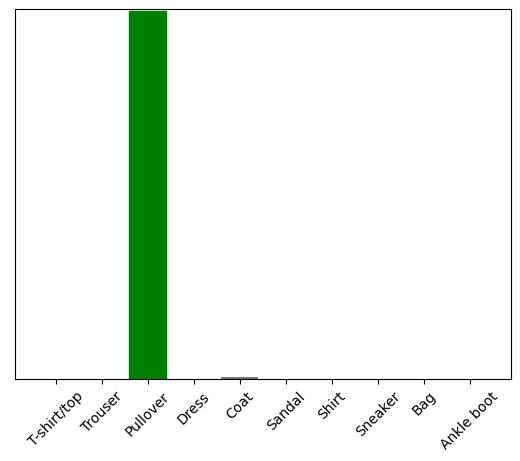

In [27]:
plot_value_array(1, prediction_single[0], y_test)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()
